<a href="https://colab.research.google.com/github/freida20git/SubjectiveQA-Rater/blob/main/notebooks/siamiseNet_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets evaluate

In [8]:
# Imports and Dataset Preparation
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset
#df = pd.read_csv('/content/drive/MyDrive/QArater/data/filtered_data.csv').fillna("") #/content/drive/MyDrive/QArater/data /filtered_data.csv
df = pd.read_csv('/content/filtered_data.csv').fillna("")


In [3]:
df.columns

Index(['qa_id', 'question_title', 'question_body', 'answer', 'category',
       'host', 'question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
   

In [ ]:
NO question_asker_intent_understanding
NO question_body_critical
NO question_type_spelling
NO question_expect_short_answer
NO question_fact_seeking
NO question_has_commonly_accepted_answer
NO question_multi_intent
NO question_not_really_a_question
NO question_type_compare
NO question_type_consequence
NO question_type_definition
NO question_type_entity

question_conversational

question_opinion_seeking

Q_INTEREST question_interestingness_others,  question_interestingness_self

QA_ISTRUCTIONS question_type_instructions, answer_type_instructions

QA_PROCEDURE question_type_procedure, answer_type_procedure

QA_REASON_EXP question_type_reason_explanation, answer_type_reason_explanation

ANSWERS_QUESTION answer_satisfaction , answer_relevance , answer_helpful

QUESTION_QUALITY question_well_written

ANSWER_QUALITY answer_level_of_information , answer_plausible  , answer_well_written




In [ ]:
!pip install transformers datasets scikit-learn pandas torch

In [9]:
df=df.drop(columns=['qa_id', 'host'])
df.head()

,question_title,question_body,answer,category,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",LIFE_ARTS,1.000000,0.333333,0.000000,0.0,0.0,0.0,...,1.0,1.0,0.666667,1.0,1.0,0.8,1.0,0.0,0.0,1.0
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,CULTURE,1.000000,1.000000,0.000000,0.5,1.0,1.0,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,SCIENCE,0.888889,0.666667,0.000000,1.0,1.0,1.0,...,0.777778,0.777778,0.555556,1.0,1.0,0.666667,0.0,0.333333,1.0,0.888889
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",CULTURE,0.888889,0.666667,0.666667,1.0,1.0,1.0,...,0.888889,0.833333,0.333333,0.833333,1.0,0.8,0.0,0.0,1.0,1.0
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,1.000000,0.666667,0.000000,1.0,1.0,1.0,...,1.0,1.0,0.666667,1.0,1.0,0.8,1.0,0.0,1.0,1.0


In [14]:
import pandas as pd

# Define groups
groups = {
    "question_conversational": ["question_conversational"],
    "question_opinion_seeking": ["question_opinion_seeking"],
    "Q_INTEREST": ["question_interestingness_others", "question_interestingness_self"],
    "QA_INSTRUCTIONS": ["question_type_instructions", "answer_type_instructions"],
    "QA_PROCEDURE": ["question_type_procedure", "answer_type_procedure"],
    "QA_REASON_EXP": ["question_type_reason_explanation", "answer_type_reason_explanation"],
    "ANSWERS_QUESTION": ["answer_satisfaction", "answer_relevance", "answer_helpful"],
    "QUESTION_QUALITY": ["question_well_written"],
    "ANSWER_QUALITY": ["answer_level_of_information", "answer_plausible", "answer_well_written"]
}

# Compute mean for each group
for group_name, metrics in groups.items():
    df[group_name] = df[metrics].mean(axis=1)

# Remove unnecessary columns
irrelevant = [
    "question_asker_intent_understanding", "question_body_critical", "question_type_spelling",
    "question_expect_short_answer", "question_fact_seeking", "question_has_commonly_accepted_answer",
    "question_multi_intent", "question_not_really_a_question", "question_type_compare",
    "question_type_consequence", "question_type_definition", "question_type_entity", "question_type_choice"]

# List of all original metric columns to drop
to_drop = irrelevant + sum(groups.values(), [])
# Remove 'question_conversational' and 'question_opinion_seeking' so they are NOT dropped
to_drop = [col for col in to_drop if col not in ['question_conversational', 'question_opinion_seeking']]
df = df.drop(columns=to_drop)


# Final targets
target_columns = list(groups.keys())

df[target_columns] = df[target_columns].apply(pd.to_numeric, errors='coerce')

# dealing with NaN values:

In [11]:
# List all metric columns
metric_cols = sum(groups.values(), [])

# Check which rows in each metric column have problematic (non-numeric) values
for col in metric_cols:
    # Attempt conversion, marking problematic cells with True
    mask = pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()
    if mask.any():
        print(f"Non-numeric values found in column '{col}':")
        print(df.loc[mask, col].unique())


Non-numeric values found in column 'question_type_instructions':
['']
Non-numeric values found in column 'answer_type_instructions':
['']
Non-numeric values found in column 'question_type_procedure':
['']
Non-numeric values found in column 'answer_type_procedure':
['']
Non-numeric values found in column 'question_type_reason_explanation':
['']
Non-numeric values found in column 'answer_type_reason_explanation':
['']
Non-numeric values found in column 'answer_satisfaction':
['']
Non-numeric values found in column 'answer_relevance':
['']
Non-numeric values found in column 'answer_helpful':
['']
Non-numeric values found in column 'question_well_written':
['']
Non-numeric values found in column 'answer_level_of_information':
['']
Non-numeric values found in column 'answer_plausible':
['']
Non-numeric values found in column 'answer_well_written':
['']


In [12]:
metric_cols = sum(groups.values(), [])

# Find rows where any metric column has ''
mask = df[metric_cols].isin(['']).any(axis=1)

# Drop those rows
df = df[~mask].reset_index(drop=True)


In [13]:
# List all metric columns
metric_cols = sum(groups.values(), [])

# Check which rows in each metric column have problematic (non-numeric) values
for col in metric_cols:
    # Attempt conversion, marking problematic cells with True
    mask = pd.to_numeric(df[col], errors='coerce').isna() & df[col].notna()
    if mask.any():
        print(f"Non-numeric values found in column '{col}':")
        print(df.loc[mask, col].unique())


#continue:

In [15]:
target_columns

['question_conversational',
 'question_opinion_seeking',
 'Q_INTEREST',
 'QA_INSTRUCTIONS',
 'QA_PROCEDURE',
 'QA_REASON_EXP',
 'ANSWERS_QUESTION',
 'QUESTION_QUALITY',
 'ANSWER_QUALITY']

In [16]:
df

,question_title,question_body,answer,category,question_conversational,question_opinion_seeking,Q_INTEREST,QA_INSTRUCTIONS,QA_PROCEDURE,QA_REASON_EXP,ANSWERS_QUESTION,QUESTION_QUALITY,ANSWER_QUALITY
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",LIFE_ARTS,0.000000,1.000000,1.000000,1.0,0.0,0.0,0.933333,1.0,0.888889
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,CULTURE,0.000000,0.000000,0.444444,0.0,0.0,0.5,0.814815,0.888889,0.777778
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,SCIENCE,0.000000,0.333333,0.555556,0.5,0.333333,0.666667,0.814815,0.777778,0.814815
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",CULTURE,0.666667,0.000000,0.444444,0.0,0.0,0.5,0.877778,0.888889,0.722222
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,0.000000,0.000000,0.666667,1.0,0.0,1.0,0.933333,1.0,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,Mutually generics,"Given posets $P,Q\in M$, I would like to know ...","Another fact to add to Joel's list, one which ...",SCIENCE,0.000000,0.000000,0.833333,0.0,0.0,0.5,0.577778,1.0,0.777778
2546,"Psychology behind $0.99 for paid apps, but $1....",I've noticed a trend (at least on the Google P...,"I know this question is old, and the purpose o...",TECHNOLOGY,0.333333,0.666667,0.555556,0.0,0.0,1.0,0.918519,0.777778,0.814815
2547,What does mathematics have to do with programm...,I just started a diploma in software developme...,Two specific examples where a math education i...,TECHNOLOGY,0.000000,0.000000,0.777778,0.0,0.0,0.5,0.785185,1.0,0.888889
2548,How to add a website to Safari Top Sites manua...,How to add a website to Safari Top Sites manua...,You can add it by dragging URL to top sites wi...,TECHNOLOGY,0.000000,0.000000,0.666667,0.666667,0.333333,0.0,0.977778,0.777778,0.851852


In [17]:
df.columns
len(df.columns)

13

In [25]:
df[target_columns] = df[target_columns].apply(pd.to_numeric, errors='coerce')

**Dataset and Tokenization**

In [39]:
# TOKENIZATION:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class QADataset(Dataset):
    def __init__(self, df, targets, max_len=256):
        self.questions = (df['question_title'] + " " + df['question_body']).tolist()
        self.answers = df['answer'].tolist()
        self.targets = df[targets].values
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q_enc = tokenizer( self.questions[idx], truncation=True, padding='max_length',
                          max_length=self.max_len, return_tensors='pt' )
        a_enc = tokenizer( self.answers[idx], truncation=True, padding='max_length',
                          max_length=self.max_len, return_tensors='pt')

        return {
            'q_input_ids': q_enc['input_ids'].squeeze(0),
            'q_attention_mask': q_enc['attention_mask'].squeeze(0),
            'a_input_ids': a_enc['input_ids'].squeeze(0),
            'a_attention_mask': a_enc['attention_mask'].squeeze(0),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }


In [40]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset into train and validation (80/20 split)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create Dataset objects
train_dataset = QADataset(train_df, target_columns, max_len=256)
val_dataset = QADataset(val_df, target_columns, max_len=256)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


**Siamese RoBERTa Model**

In [20]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class SiameseRoBERTa(nn.Module):
    def __init__(self, dropout=0.2, out_dim=7):
        super().__init__()
        self.roberta_q = RobertaModel.from_pretrained("roberta-base")
        self.roberta_a = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(1536, out_dim)  # 768*2 if concat
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.regressor.weight)
        self.regressor.bias.data.zero_()

    def forward(self, input_ids_q, attention_mask_q, input_ids_a, attention_mask_a):
        q_out = self.roberta_q(input_ids=input_ids_q, attention_mask=attention_mask_q).last_hidden_state
        a_out = self.roberta_a(input_ids=input_ids_a, attention_mask=attention_mask_a).last_hidden_state

        # Mean pooling to average only the real tokens
        q_vec = (q_out * attention_mask_q.unsqueeze(-1)).sum(1) / attention_mask_q.sum(1, keepdim=True)
        a_vec = (a_out * attention_mask_a.unsqueeze(-1)).sum(1) / attention_mask_a.sum(1, keepdim=True)

        # Combine (concatenate)
        combined = torch.cat([q_vec, a_vec], dim=1)
        output = self.regressor(self.dropout(combined))
        return output


**Metrcis**

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, pearsonr

def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    spearman = [spearmanr(y_true[:, i], y_pred[:, i]).correlation for i in range(y_true.shape[1])]
    pearson = [pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])]
    return mae, mse, spearman, pearson


**Train & Eval Functions**

In [35]:
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    preds, trues = [], []

    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        for k in batch:
            batch[k] = batch[k].to(device)
        output = model(batch['q_input_ids'], batch['q_attention_mask'],
                       batch['a_input_ids'], batch['a_attention_mask'])
        loss = F.mse_loss(output, batch["targets"])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.append(output.detach())
        trues.append(batch["targets"])

    preds = torch.cat(preds)
    trues = torch.cat(trues)
    mae, mse, spearman, pearson = compute_metrics(trues, preds)
    return total_loss / len(dataloader), mae, mse, spearman, pearson

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    preds, trues = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            for k in batch:
                batch[k] = batch[k].to(device)
            output = model(batch['q_input_ids'], batch['a_attention_mask'],
                           batch['a_input_ids'], batch['a_attention_mask'])
            loss = F.mse_loss(output, batch["targets"])
            total_loss += loss.item()
            preds.append(output)
            trues.append(batch["targets"])

    preds = torch.cat(preds)
    trues = torch.cat(trues)
    mae, mse, spearman, pearson = compute_metrics(trues, preds)
    return total_loss / len(dataloader), mae, mse, spearman, pearson


**Train and plot**

**Training Script with Plotting**

In [69]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    train_losses, val_losses = [], []
    all_spearman, all_pearson = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_mae, train_mse, train_spearman, train_pearson = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_mae, val_mse, val_spearman, val_pearson = eval_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        all_spearman.append(val_spearman)
        all_pearson.append(val_pearson)

        # Plot Spearman
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(val_spearman)), val_spearman)
        plt.xticks(ticks=range(len(target_columns)), labels=target_columns, rotation=45, ha='right')
        plt.title(f"Epoch {epoch+1} - Spearman per Target")
        plt.xlabel("Target")
        plt.ylabel("Spearman Correlation")
        plt.ylim(-1, 1)
        plt.grid(True)
        plt.show()

        # Plot Pearson
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(val_pearson)), val_pearson, color='orange')
        plt.xticks(ticks=range(len(target_columns)), labels=target_columns, rotation=45, ha='right')
        plt.title(f"Epoch {epoch+1} - Pearson per Target")
        plt.xlabel("Target")
        plt.ylabel("Pearson Correlation")
        plt.ylim(-1, 1)
        plt.grid(True)
        plt.show()

    # Plot Loss after training
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.66it/s]


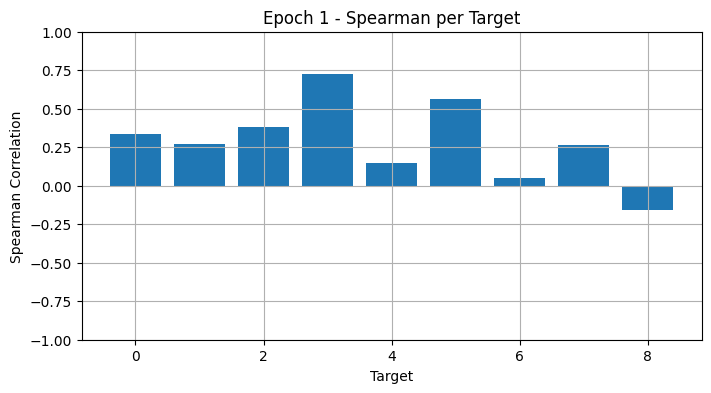

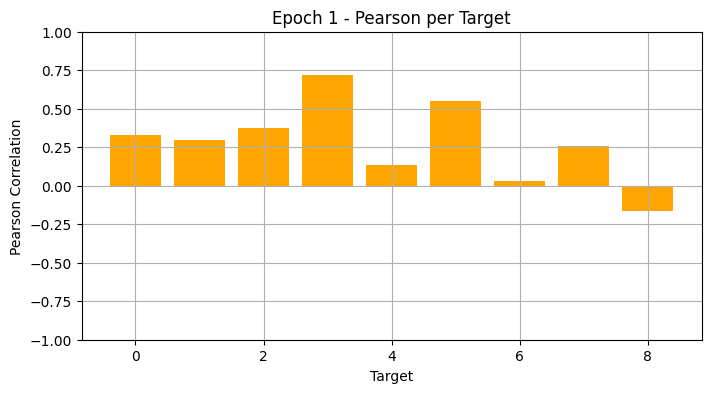


Epoch 2/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.73it/s]


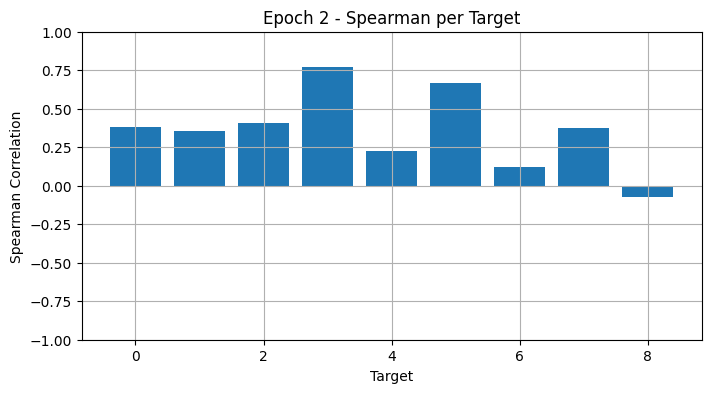

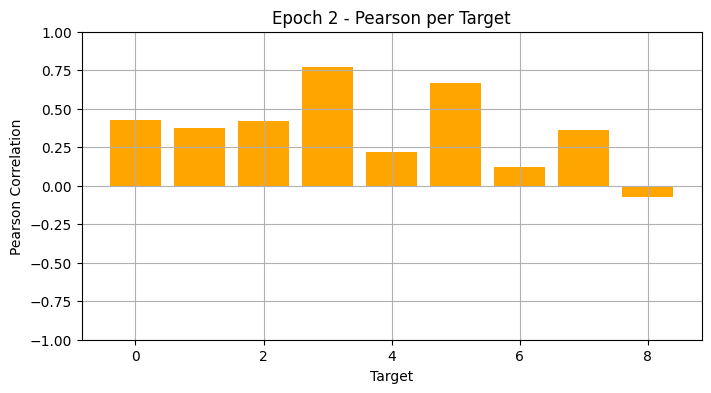


Epoch 3/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.72it/s]


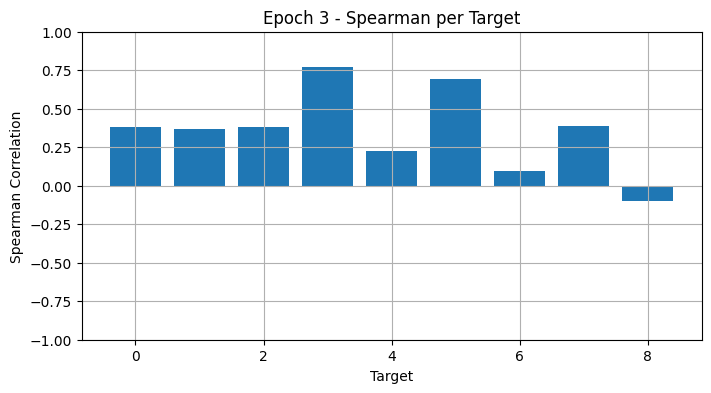

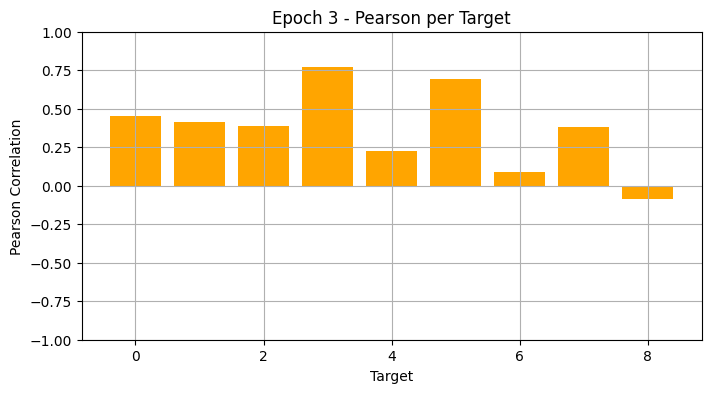


Epoch 4/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.70it/s]


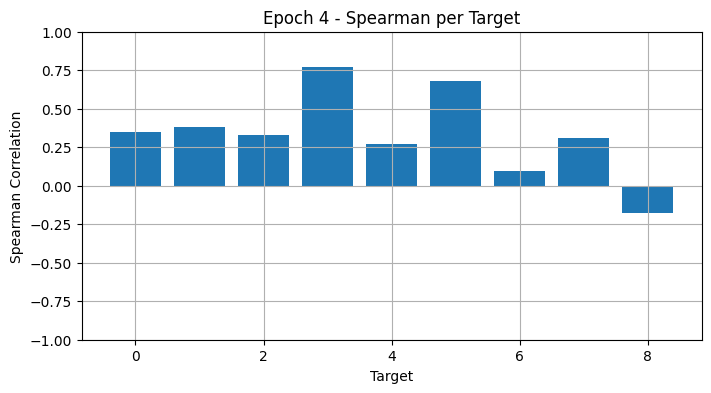

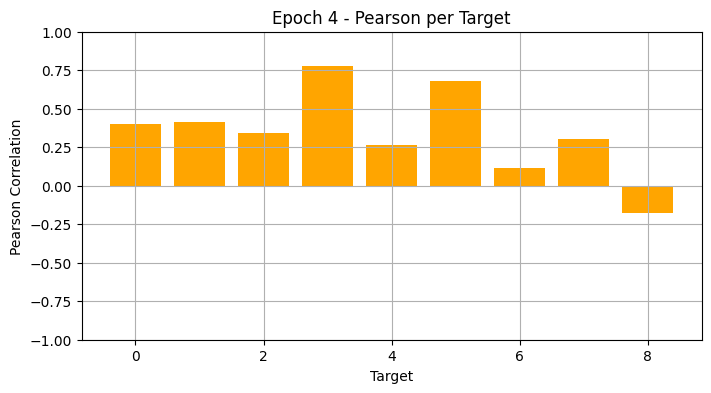


Epoch 5/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.68it/s]


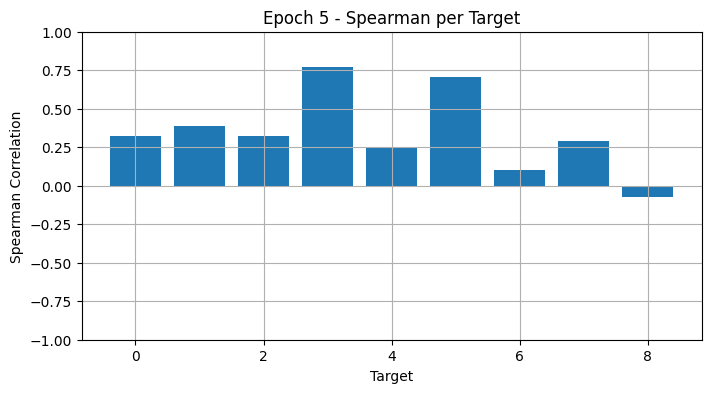

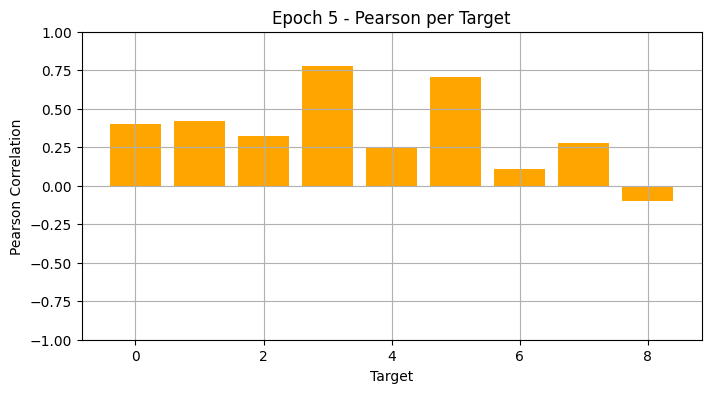


Epoch 6/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.68it/s]


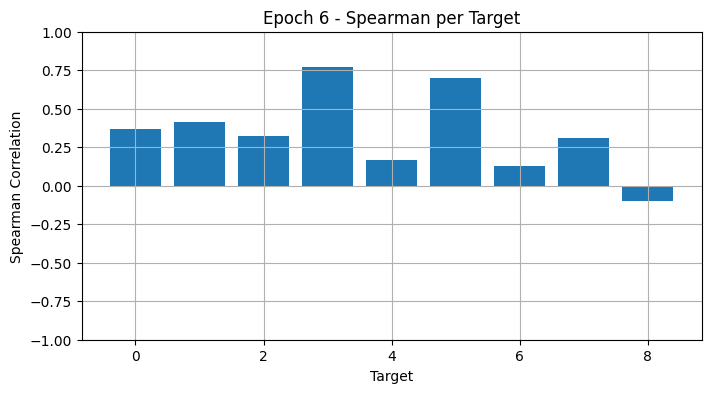

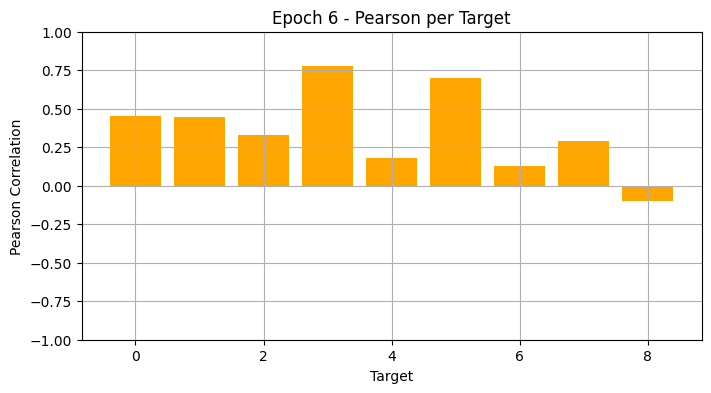


Epoch 7/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.68it/s]


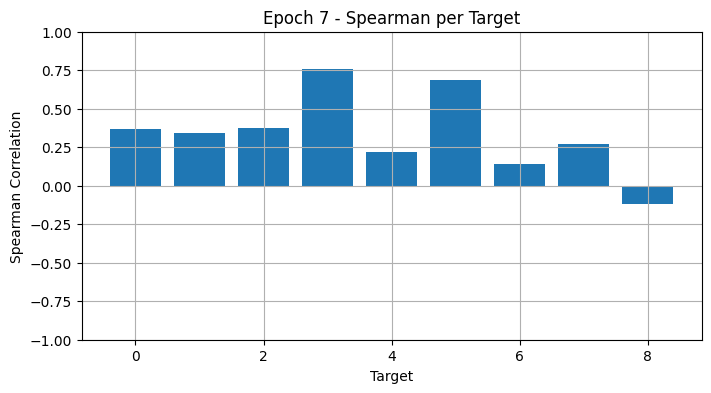

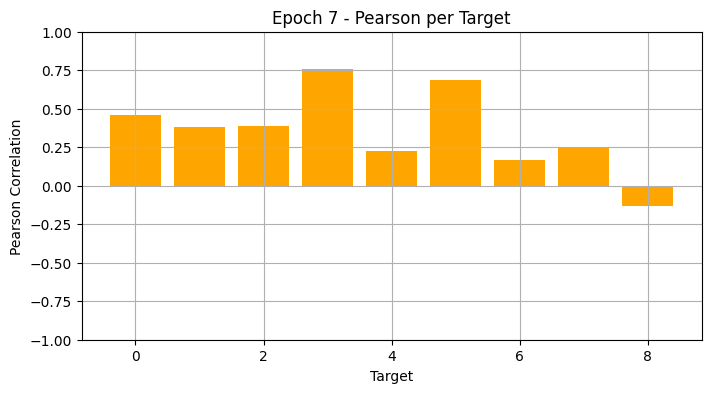


Epoch 8/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.67it/s]


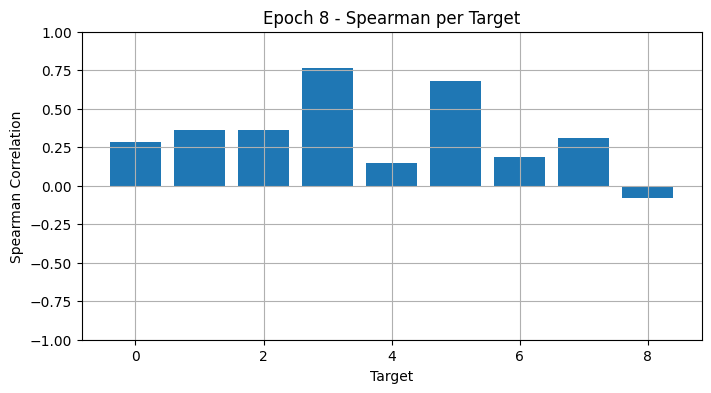

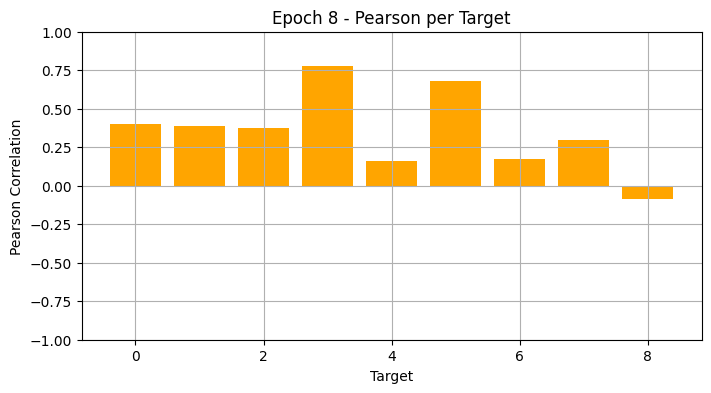


Epoch 9/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.69it/s]


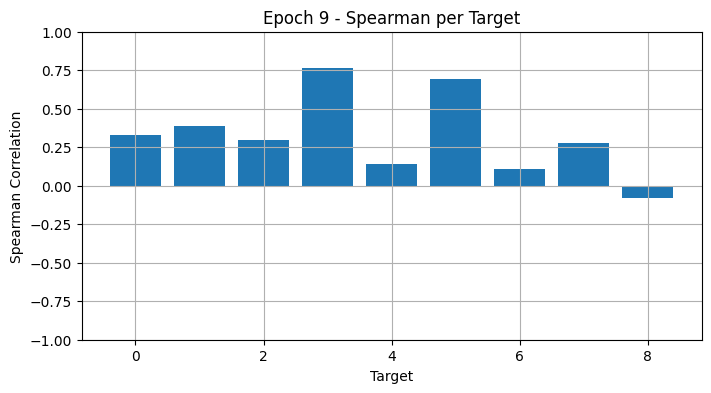

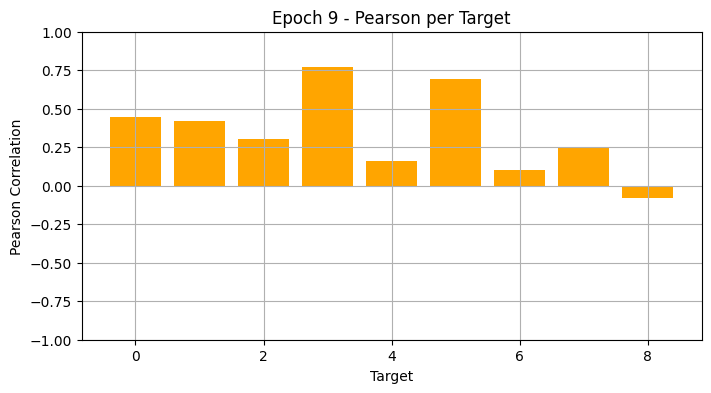


Epoch 10/10


  0%|          | 0/255 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/64 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 64/64 [00:17<00:00,  3.69it/s]


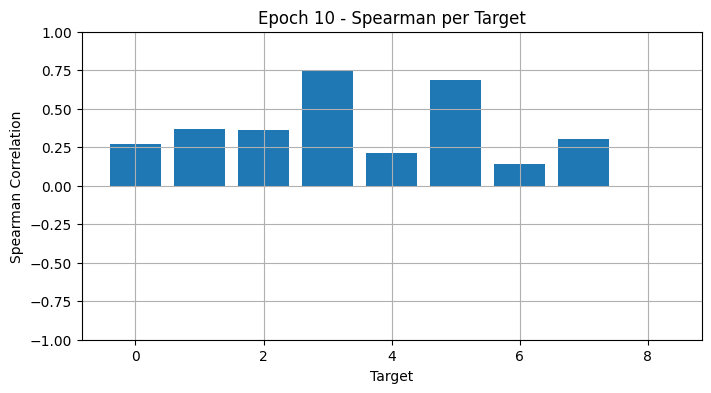

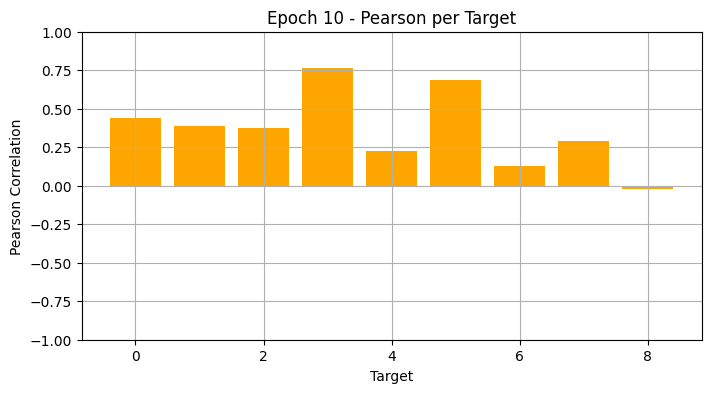

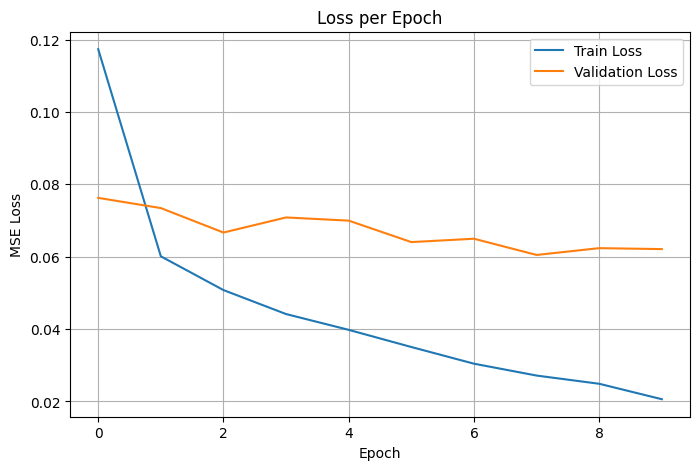

In [41]:
import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseRoBERTa(out_dim=len(target_columns))  # initialize model
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 10

train_model(model, train_loader, val_loader, optimizer, device, num_epochs)


**order of x-axis in correlation plot:**

question_conversational, question opinion seeking, Q interest, QA_procedure, QA_INSTRUCTIONS, QA_REASON_EXP, ANSWERS_QUESTION, QUESTION_QUALITY, ANSWER_QUALITY

In [44]:
torch.save(model.state_dict(), f"siamese_roberta_epoch10.pth")

# INFERENCE

In [45]:

model = SiameseRoBERTa(out_dim=len(target_columns))
model.load_state_dict(torch.load('/content/siamese_roberta_epoch10.pth', map_location=device))
model.to(device)
model.eval()


def predict(model, question_title, question_body, answer):
    model.eval()
    with torch.no_grad():
        q_text = "Title: " + question_title + " [SEP] " + question_body
        a_text = answer

        q_tokens = tokenizer(q_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        a_tokens = tokenizer(a_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

        q_ids = q_tokens["input_ids"].to(device)
        q_mask = q_tokens["attention_mask"].to(device)
        a_ids = a_tokens["input_ids"].to(device)
        a_mask = a_tokens["attention_mask"].to(device)

        pred = model(q_ids, q_mask, a_ids, a_mask)
        return pred.squeeze(0).cpu().numpy()  # shape: (30,)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


the warning above matters if .pooled() layers are used, nut this model doesnt use those, instead we took the last_hidden layer so we can igbore it.

In [67]:
def plot_predictions(preds, title):
    plt.figure(figsize=(14, 6))  # Taller plot (was 14x4)
    bars = plt.bar(target_columns, preds, color='skyblue')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.1)  # Allow space above bars for text
    plt.ylabel("Predicted Score")
    plt.title(title)
    plt.grid(True, axis='y')

    # Add value labels on top of bars
    for bar, score in zip(bars, preds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


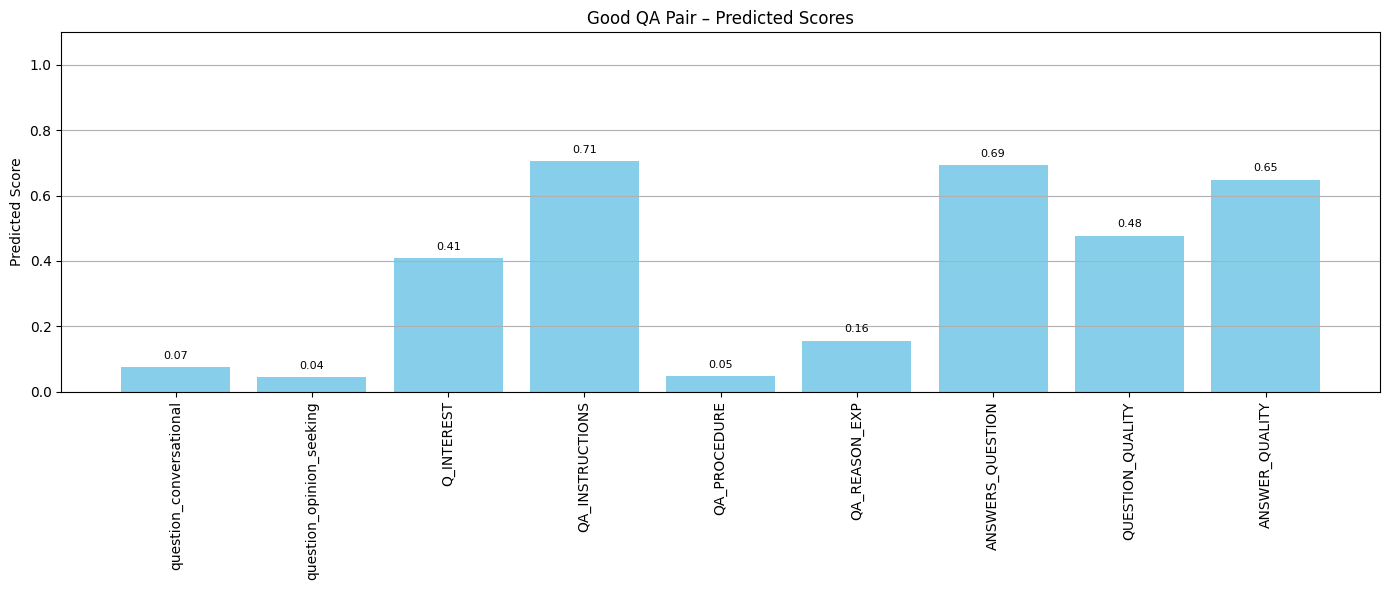

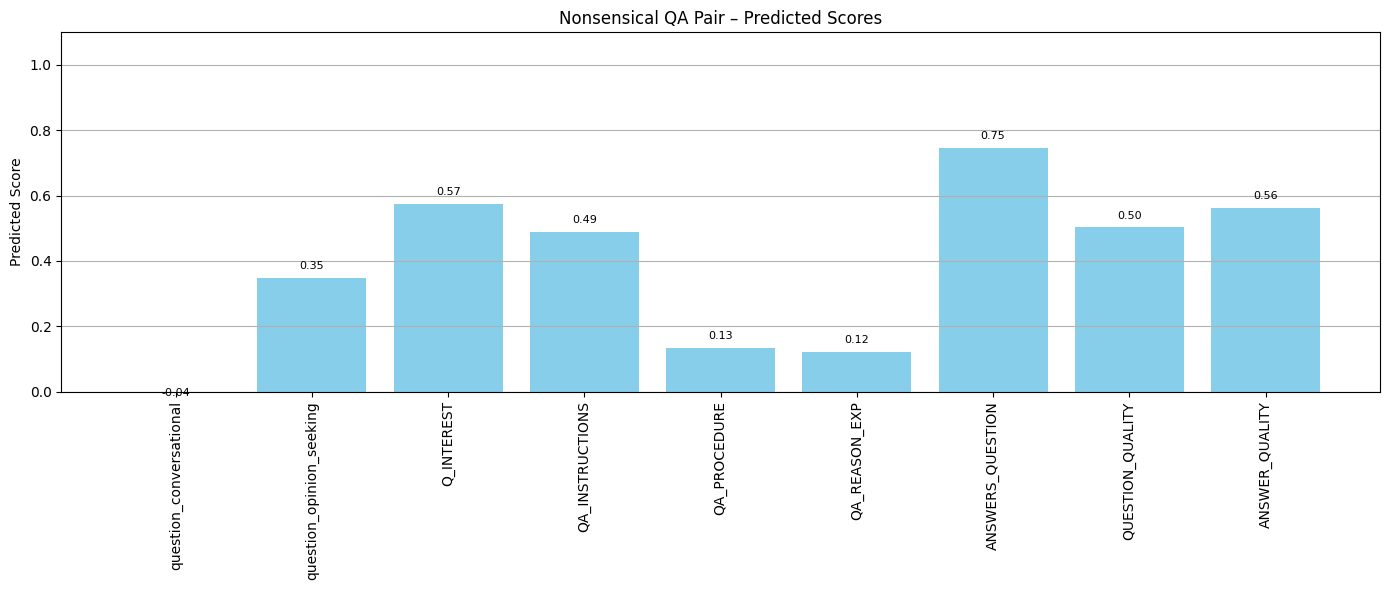

In [68]:
# Metric names for x-axis
metric_names = metric_cols  # same order as your label columns

# A good QA pair
qa_good = {
    "question_title": "How to 'print hello' world in python?",
    "question_body": "syntax help",
    "answer": "print('hello world') and youre done!"
}
qa_bad = {
    "question_title": "How to print hello world in python?",
    "question_body": "syntax help",
     "answer": "banana"
}

pred_good = predict(model, **qa_good)
pred_bad = predict(model, **qa_bad)

plot_predictions(pred_good, "Good QA Pair – Predicted Scores")
plot_predictions(pred_bad, "Nonsensical QA Pair – Predicted Scores")

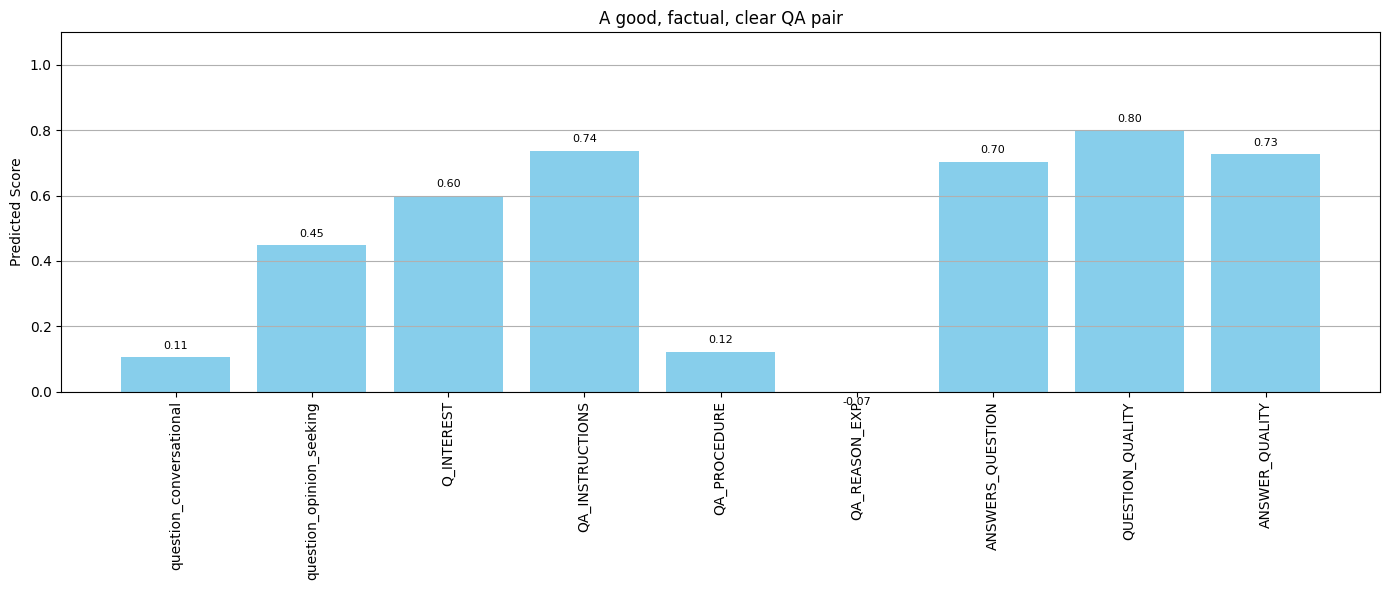

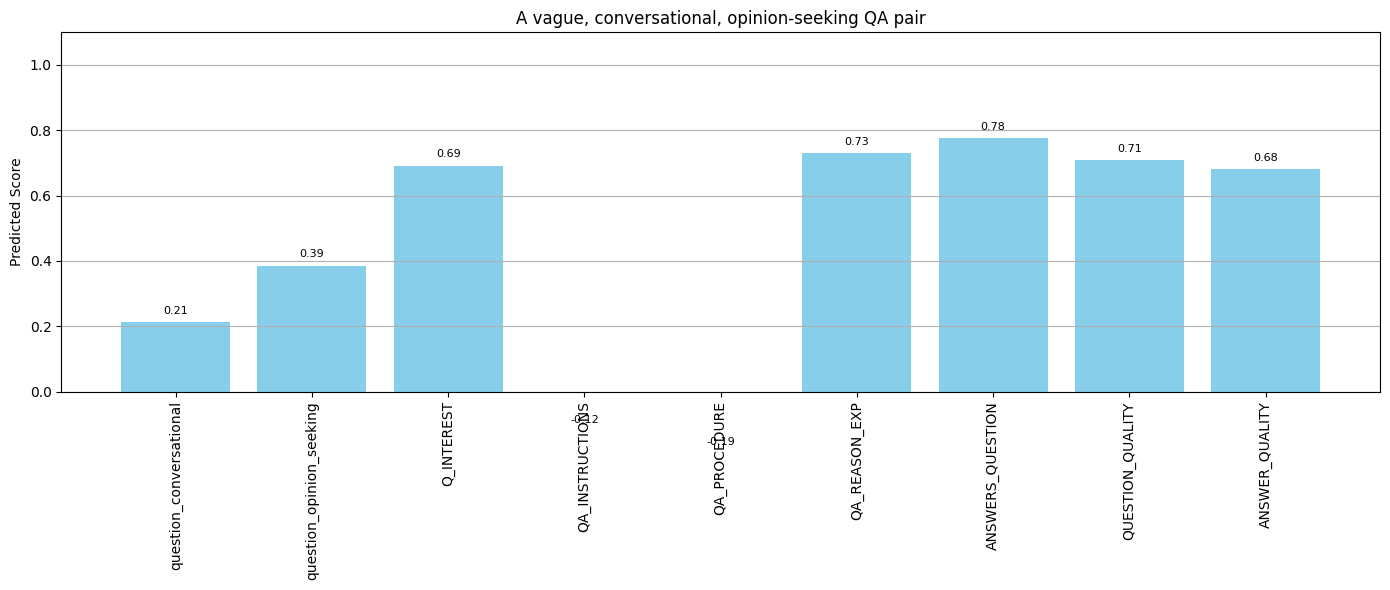

In [66]:
# Metric names for x-axis
metric_names = metric_cols  # same order as your label columns

# A good, factual, clear QA pair
qa_first = {
    "question_title": "How can I clean a burnt stainless steel pot?",
    "question_body": "I've accidentally burnt food in my stainless steel pot. What are the most effective and safe methods to clean it without damaging the pot?",
    "answer": "Fill the pot with water and add a few tablespoons of baking soda. Bring it to a boil, let it cool, then scrub with a non-abrasive sponge. For stubborn stains, white vinegar can help."
}

# A vague, conversational, opinion-seeking QA pair
qa_contrast = {
    "question_title": "Why do some people hate cooking?",
    "question_body": "I was talking with my roommate and he said he hates cooking. I don’t get it. I love it. Why do people feel so differently?",
    "answer": "Well, everyone is different. Some people just don’t enjoy the process or find it stressful. Others might just not have learned how to cook well or associate it with chores."
}
pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)


plot_predictions(pred_first, "A good, factual, clear QA pair")
plot_predictions(pred_contrast, "A vague, conversational, opinion-seeking QA pair")


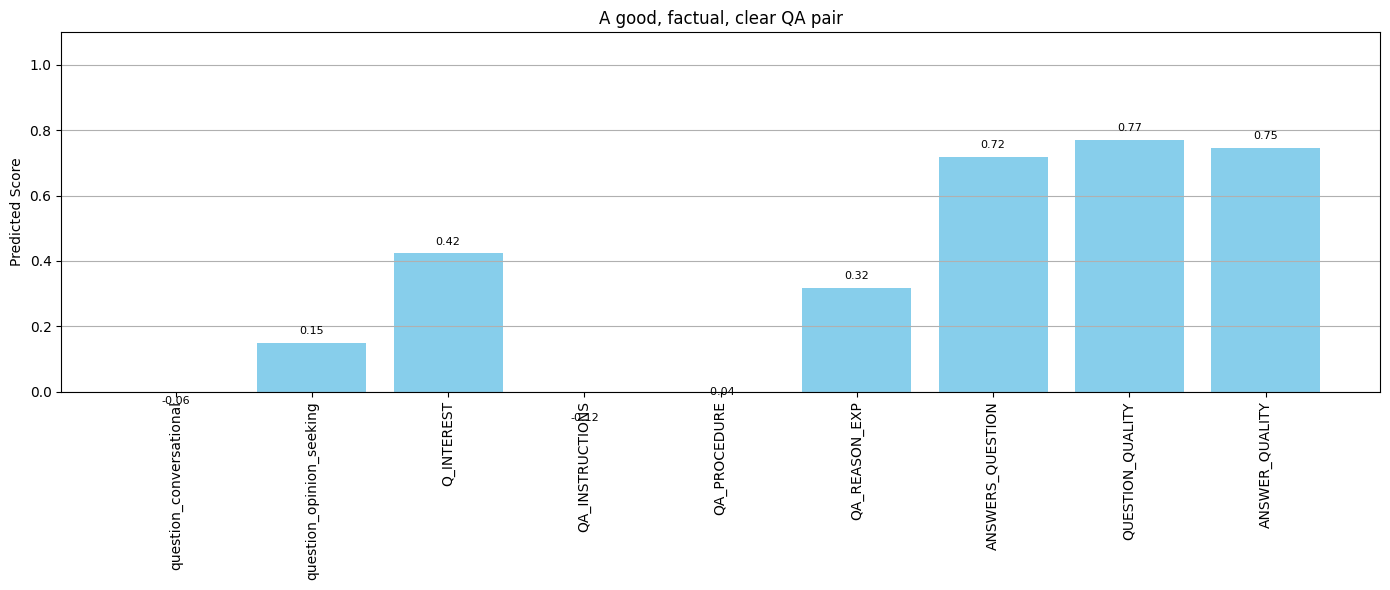

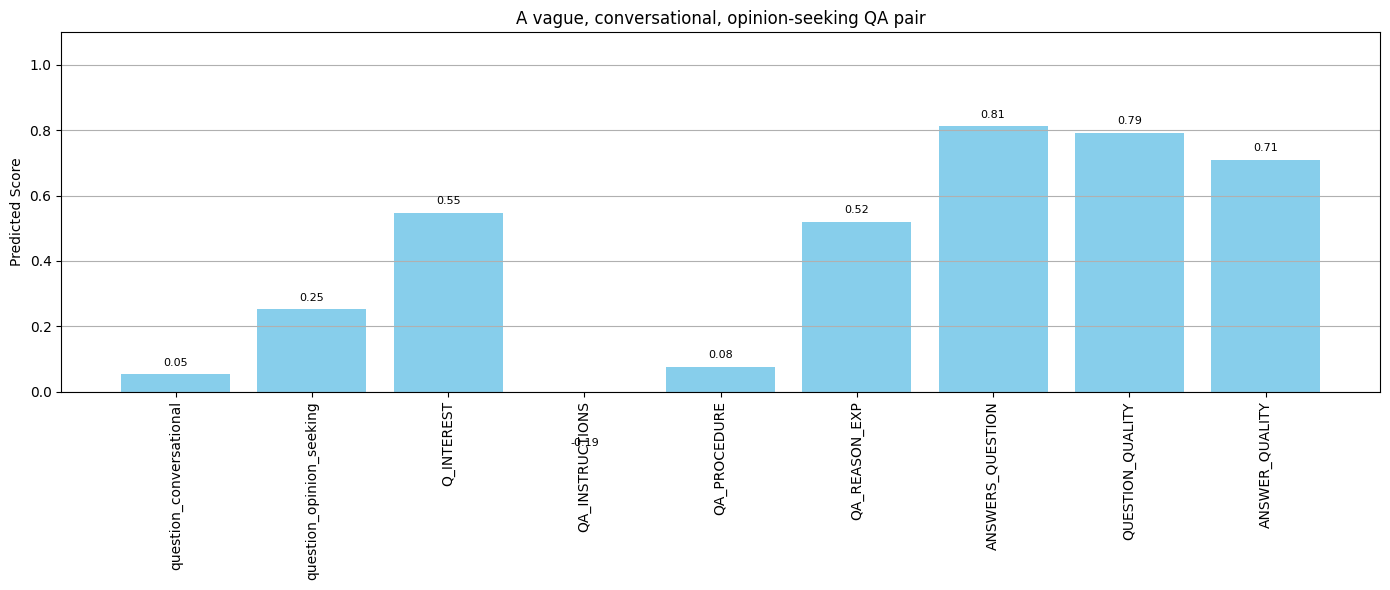

In [62]:
qa_first = {
    "question_title": "What is the difference between supervised and unsupervised learning?",
    "question_body": "I've been studying machine learning and I keep seeing the terms 'supervised' and 'unsupervised' learning. Can someone explain the difference in simple terms, with an example if possible?",
    "answer": "Sure! In supervised learning, the model is trained on labeled data—meaning the correct answers are provided. For example, predicting house prices based on known sales data. In unsupervised learning, the data is unlabeled and the model tries to find structure in the input, like clustering customers into groups based on purchasing behavior."
}
qa_contrast = {
    "question_title": "What’s new in the latest iOS update?",
    "question_body": "I heard there was an update. Is it good? What’s the deal with it? ",
    "answer": "Android is actually better in my opinion. I don’t like iPhones at all."
}
pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)

plot_predictions(pred_first, "A good, factual, clear QA pair")
plot_predictions(pred_contrast, "A vague, conversational, opinion-seeking QA pair")



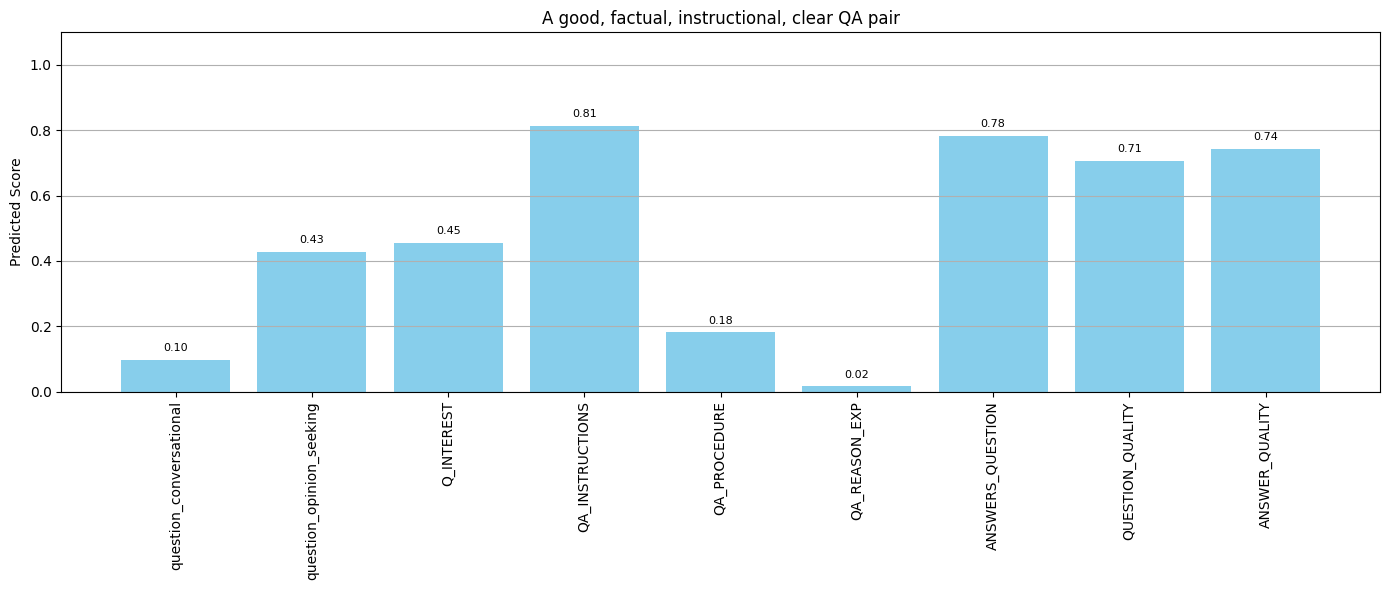

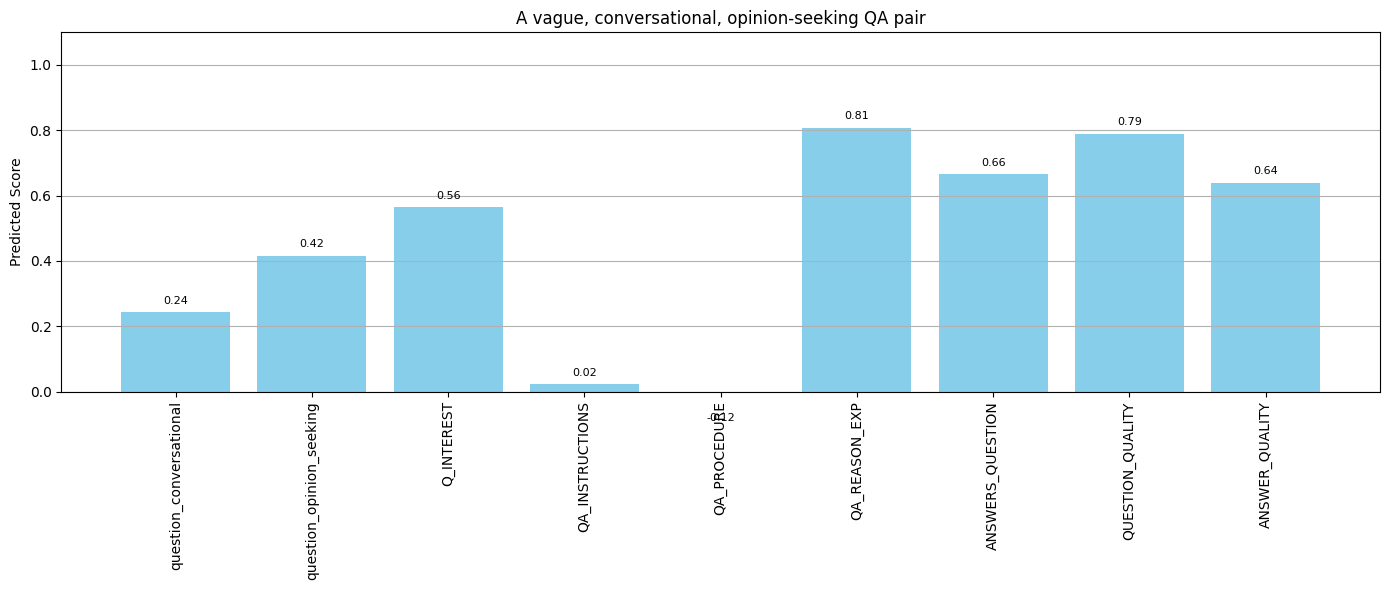

In [63]:
qa_first = {
    "question_title": "How can I reverse a list in Python?",
    "question_body": "I have a list of integers in Python and I want to reverse the order of elements. What's the most Pythonic way to do it?",
    "answer": "You can reverse a list in Python using slicing: `reversed_list = my_list[::-1]`. Alternatively, you can use the built-in `reversed()` function: `list(reversed(my_list))`. Both are commonly used."
}
qa_contrast = {
    "question_title": "Why is Python bad?",
    "question_body": "I’ve heard people say Python is not good for real devs. Is that true?",
    "answer": "I think Java is way better than Python anyway. Everyone should just switch to Java.",
}


pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)

plot_predictions(pred_first, "A good, factual, instructional, clear QA pair")
plot_predictions(pred_contrast, "A vague, conversational, opinion-seeking QA pair")

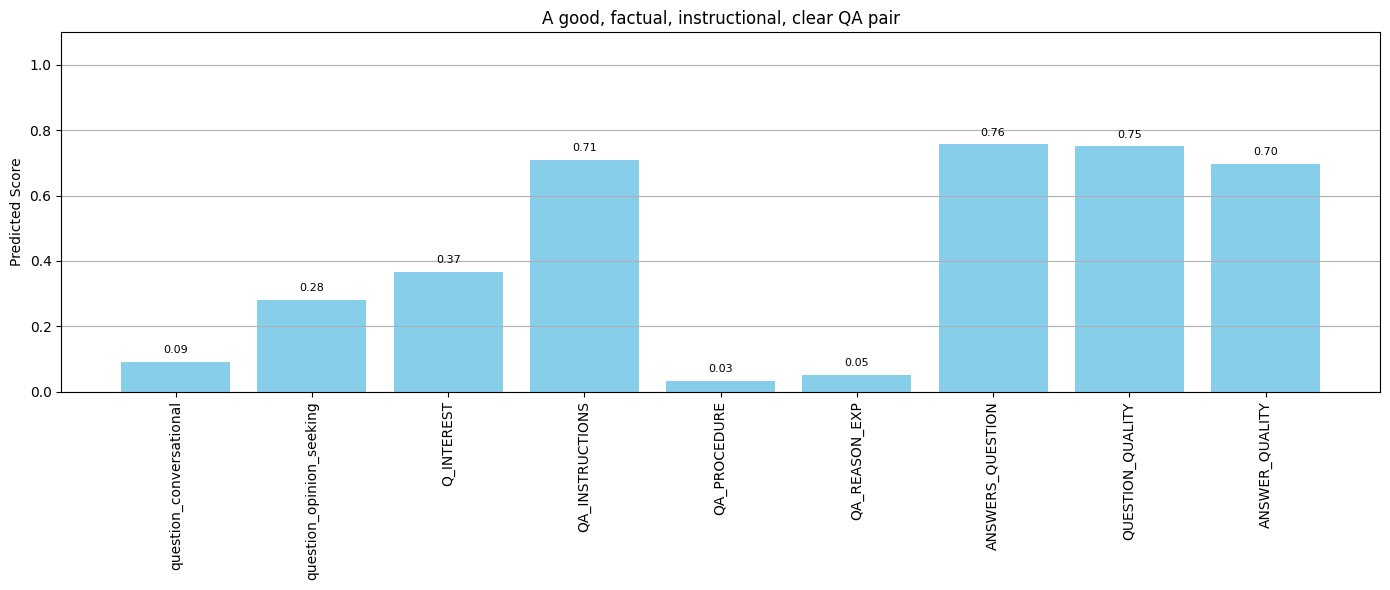

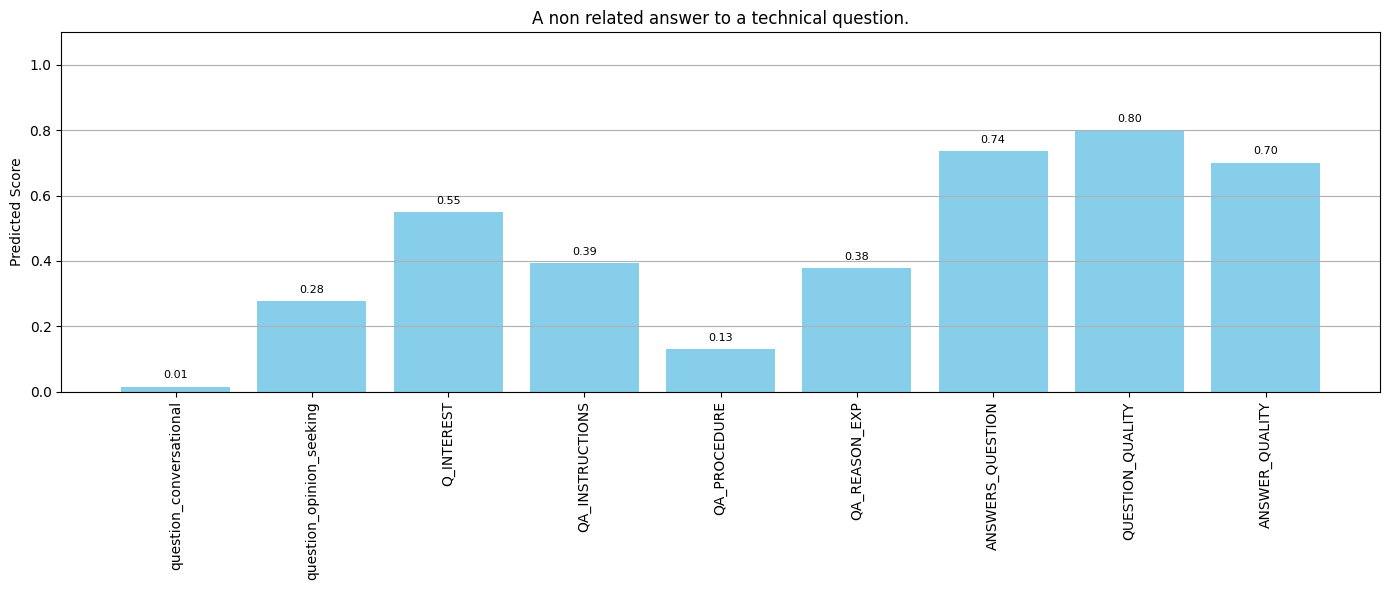

In [65]:
qa_first = {
    "question_title": "How to convert a list of integers to a comma-separated string in Python?",
    "question_body": "I have a list like `[1, 2, 3, 4]` and I want to convert it to the string `'1,2,3,4'`. What's the cleanest way to do this in Python?",
    "answer": "You can use the `join` method with a generator expression: `','.join(str(i) for i in [1, 2, 3, 4])`. This will give you the output `'1,2,3,4'`."
}
qa_contrast = {
    "question_title": "How to convert a list of integers to a comma-separated string in Python?",
    "question_body": "I have a list like `[1, 2, 3, 4]` and I want to convert it to the string `'1,2,3,4'`. What's the cleanest way to do this in Python?",
    "answer": "The mating habits of penguins are fascinating. In cold climates, they huddle together to stay warm and often take turns being on the outside of the group."
}


pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)

plot_predictions(pred_first, "A good, factual, instructional, clear QA pair")
plot_predictions(pred_contrast, "A non related answer to a technical question.")

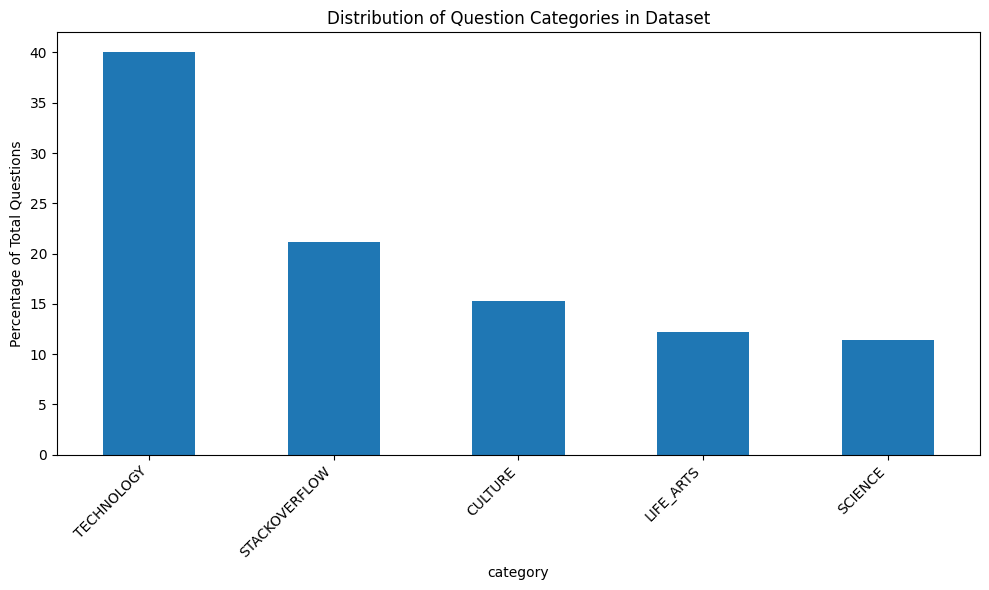

In [54]:
import matplotlib.pyplot as plt

# Count percentages per category
category_percentages = df['category'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(10, 6))
category_percentages.plot(kind='bar')
plt.ylabel('Percentage of Total Questions')
plt.title('Distribution of Question Categories in Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
